# 3  -Data cleansing

The data cleansing process includes the treatment of the data to achieve completeness and reduce the bias caused by errors in the data.

Data cleansing includes:

○ Treatment of outliers

○ Treatment of missingness

In [1]:
# Import libraries:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import iqr
from scipy import stats
from scipy.stats import ks_2samp
from itertools import combinations
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Using the ODBC:
""" 
driver_name = "SQL Server Native Client 11.0"
server = "ITZIK\SQLEXPRESS"
dbname = "Berlin"
"""

' \ndriver_name = "SQL Server Native Client 11.0"\nserver = "ITZIK\\SQLEXPRESS"\ndbname = "Berlin"\n'

In [3]:
#Expanding the output display to see more rows and columns:
pd.set_option('display.max_rows', 200 , 'display.max_columns', 200)

In [4]:
#read the data:
"""
conn = pyodbc.connect('Driver={};'
                      'Server={};'
                      'Database={};'
                      'Trusted_Connection=yes;'.format(driver_name, server, dbname))




df_flat_table = pd.read_sql_query('SELECT * FROM db01.FINAL_TABLE',conn)
"""
df_flat_table = pd.read_csv("flat_file.csv")

In [5]:
#Displaying the first 3 rows of dataframe using head() method:
df_flat_table.head(3)

,Unnamed: 0,listing_id,name,target_start_date_period,target_end_date_period,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,target_avg_dollar_price_in_period,start_date_previous_period,end_date_previous_period,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,notes,transit,access,interaction,house_rules,neighborhood_overview,host_about,host_since,DaysPassed_host_since,picture_url,host_url,host_location,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,market,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,first_review,DaysPassed_first_review,calendar_last_scraped,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,concat_comments,size,concat_comments_polarity,concat_comments_subjectivity,concat_comments_sentiment
0,0,7071,BrightRoom with sunny greenview!,2019-06-01,2019-08-31,92,92,1,NaN,2018-11-07,2019-05-31,206,180,0.87,44.3846,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42.0,2.0,197.0,2018-11-04,1042.0,1.75,1.0,26.0,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",Cozy and large room in the beautiful district ...,none,I hope you enjoy your stay to the fullest! Ple...,Best access to other parts of the city via pub...,"The guests have access to the bathroom, a smal...",I am glad if I can give you advice or help as ...,Please take good care of everything during you...,"Great neighborhood with plenty of Caf��s, Bake...","I'm a creative person, adventurer, and travele...",2009-05-16,4501.0,https://a0.muscache.com/im/pictures/21278/32a1...,https://www.airbnb.com/users/show/17391,"Berlin, Berlin, Germany",within an hour,1.0,t,https://a0.muscache.com/im/pictures/user/48c3d...,https://a0.muscache.com/im/pictures/user/48c3d...,Prenzlauer Berg,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",Helmholtzplatz,Pankow,Berlin,Berlin,10437.0,"Berlin, Germany",Berlin,DE,Germany,t,Apartment,2.0,1.0,1.0,2.0,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",NaN,NaN,NaN,$0.00,$0.00,1.0,$24.00,10.0,3 days ago,15.0,26.0,26.0,2009-08-18,4407.0,2018-11-07,96.0,10.0,10.0,10.0,10.0,10.0,9.0,NaN,f,f,f,f,moderate,##������ ������������ ������������ �����������...,20.0,0.387032,0.606783,positive_sentiment
1,1,7071,BrightRoom with sunny greenview!,2019-07-01,2019-09-30,92,92,1,NaN,2018-11-07,2019-06-30,236,210,0.89,44.3846,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42.0,2.0,197.0,2018-11-04,1042.0,1.75,1.0,26.0,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",Cozy and large room in the beautiful district ...,none,I hope you enjoy your stay to the fullest! Ple...,Best access to other parts of the city via pub...,"The guests have access to

In [6]:
# changing "listing_id", "host_id" and "zipcode" type to object
df_flat_table["listing_id"] = df_flat_table["listing_id"].astype('object')
df_flat_table["host_id"] = df_flat_table["host_id"].astype('object')
df_flat_table["zipcode"] = df_flat_table["zipcode"].astype('object')

In [7]:
# Reading from SQL add some additional index columns that start with "Unnamed" - dropping these columns
columns_to_drop = [x for x in df_flat_table.columns.to_list() if x.startswith("Unnamed")]
print("dropping coulmns: ", columns_to_drop) # [Unamed..., Unamed..]
df_flat_table.drop(columns=columns_to_drop, axis=1, inplace=True)

dropping coulmns:  ['Unnamed: 0']


In [8]:
# Displaying variables cleaning_fee, extra_people, security_deposit, weekly_price', 'monthly_price
# assuming there is not always extra payment in the following columns (such as fee and deposit) - Not assuming the missing value
dollar_columns_nan_to_0 = ['cleaning_fee', 'extra_people', 'security_deposit'] 
# in case price columns are None we assume as a missing value
dollar_columns_keep_nan = ['weekly_price', 'monthly_price']
dollar_columns = dollar_columns_nan_to_0 + dollar_columns_keep_nan
df_flat_table[dollar_columns_nan_to_0 + dollar_columns_keep_nan].head(20) 

,cleaning_fee,extra_people,security_deposit,weekly_price,monthly_price
0,$0.00,$24.00,$0.00,NaN,NaN
1,$0.00,$24.00,$0.00,NaN,NaN
2,$0.00,$24.00,$0.00,NaN,NaN
3,$0.00,$24.00,$0.00,NaN,NaN
4,$0.00,$24.00,$0.00,NaN,NaN
5,$0.00,$24.00,$0.00,NaN,NaN
6,$0.00,$24.00,$0.00,NaN,NaN
7,$80.00,$10.00,$400.00,$650.00,NaN
8,$80.00,$10.00,$400.00,$650.00,NaN
9,$80.00,$10.00,$400.00,$650.00,NaN


In [9]:
#For exploration, removing the "$"-Sign and formatting as float of vars 'cleaning_fee', 'extra_people', 'security_deposit', 
# 'weekly_price', 'monthly_price'

def dollar_column_to_float_in_place(_df: pd.DataFrame, _col_name: str, replace_none_with = '$0.00'):
    if replace_none_with:
        _df[_col_name].fillna(replace_none_with, inplace=True)
    _df[_col_name] = _df[_col_name].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    pass

# for 'cleaning_fee', 'extra_people', 'security_deposit' columns None should be replaced with 0.00 beacuse it probably means there is no deposit or fee
for dollar_column in dollar_columns_nan_to_0:
    dollar_column_to_float_in_place(df_flat_table, dollar_column,'$0.00')

# for 'weekly_price', 'monthly_price' column - None means there is no price -> missing information should not be replaced with 0.00
for dollar_column in dollar_columns_keep_nan:
    dollar_column_to_float_in_place(df_flat_table, dollar_column, None)

In [10]:
# fixed!
df_flat_table[dollar_columns].head(20) 

,cleaning_fee,extra_people,security_deposit,weekly_price,monthly_price
0,0.0,24.0,0.0,NaN,NaN
1,0.0,24.0,0.0,NaN,NaN
2,0.0,24.0,0.0,NaN,NaN
3,0.0,24.0,0.0,NaN,NaN
4,0.0,24.0,0.0,NaN,NaN
5,0.0,24.0,0.0,NaN,NaN
6,0.0,24.0,0.0,NaN,NaN
7,80.0,10.0,400.0,650.0,NaN
8,80.0,10.0,400.0,650.0,NaN
9,80.0,10.0,400.0,650.0,NaN


### For Data Cleansing we select numeric columns only

In [11]:
# Arrange the columns by type

def get_dict_of_df_types(pdf: pd.DataFrame) -> dict:
    """
    Arrange dataframe columns in the dictionary by types:
    For each type having a list of columns
    """
    d_of_columns_types = {}

    for c,t in zip(pdf.columns, pdf.dtypes):
        t_str = str(t)
        if d_of_columns_types.get(t_str) == None:
            d_of_columns_types[t_str] = [c]
        else:
            d_of_columns_types[t_str].append(c)
    return d_of_columns_types

In [12]:
d_of_columns_types_local = get_dict_of_df_types(df_flat_table)
d_of_columns_types_local

{'object': ['listing_id',
  'name',
  'target_start_date_period',
  'target_end_date_period',
  'start_date_previous_period',
  'end_date_previous_period',
  'host_id',
  'host_name',
  'neighbourhood_group',
  'neighbourhood',
  'room_type',
  'last_review',
  'listing_url',
  'last_scraped',
  'summary',
  'space',
  'description',
  'experiences_offered',
  'notes',
  'transit',
  'access',
  'interaction',
  'house_rules',
  'neighborhood_overview',
  'host_about',
  'host_since',
  'picture_url',
  'host_url',
  'host_location',
  'host_response_time',
  'host_is_superhost',
  'host_thumbnail_url',
  'host_picture_url',
  'host_neighbourhood',
  'host_verifications',
  'host_has_profile_pic',
  'host_identity_verified',
  'street',
  'neighbourhood_cleansed',
  'neighbourhood_group_cleansed',
  'city',
  'state',
  'zipcode',
  'smart_location',
  'market',
  'country_code',
  'country',
  'is_location_exact',
  'property_type',
  'bed_type',
  'amenities',
  'calendar_updated',
 

In [13]:
numeric_list = d_of_columns_types_local['int64'] + d_of_columns_types_local['float64']
numeric_list

['target_num_of_day_in_period',
 'target_num_of_booked_days',
 'booked_up_target',
 'num_of_day_in_previous_period',
 'num_of_booked_days_in_previous_period',
 'target_avg_dollar_price_in_period',
 'occupancy_last_period',
 'avg_dollar_price_in_previous_period',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'DaysPassed_last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'scrape_id',
 'DaysPassed_host_since',
 'host_response_rate',
 'host_total_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'DaysPassed_first_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review

In [14]:
# Selecting the numerical cols and dropping cols irrelevant to Data Cleansing

selected_columns = numeric_list

removed_columns = ['zipcode','latitude', 'longitude', 'scrape_id']
for remove_column in removed_columns:
    if remove_column in selected_columns:
        selected_columns.remove(remove_column)

selected_columns_unique = []
# more efficient way using list(set(mylist)), but this not keeping the order
for x in selected_columns:
    if x not in selected_columns_unique:
        selected_columns_unique.append(x)


df = df_flat_table[selected_columns_unique]

In [15]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157864 entries, 0 to 157863
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   target_num_of_day_in_period            157864 non-null  int64  
 1   target_num_of_booked_days              157864 non-null  int64  
 2   booked_up_target                       157864 non-null  int64  
 3   num_of_day_in_previous_period          157864 non-null  int64  
 4   num_of_booked_days_in_previous_period  157864 non-null  int64  
 5   target_avg_dollar_price_in_period      43919 non-null   float64
 6   occupancy_last_period                  157864 non-null  float64
 7   avg_dollar_price_in_previous_period    78311 non-null   float64
 8   price                                  157864 non-null  float64
 9   minimum_nights                         157864 non-null  float64
 10  number_of_reviews                      157864 non-null  

# outliers check

In this section, We are searching for significant outliers in numeric variables.
We check each variable to determine if it has outliers and which values are considered outliers.

The methodology of the treatment in the outliers will be:

1. If the outliers is a mistaken observation - replacing the outliers with na.
2. If the outliers generate any false correlation with the outcome - replacing the outliers with na.
3. If the removal of the outliers change the distribution of the outcome but not the correlation - replacing the outliers with na.
4. If the removal of the outliers change the both correlation and the distribution of the outcome - we can't replace the outliers with na. In this case we will need to perform a data transformation or make the variable categorical and thus divide it into groups that one of which will be "missing" or use models to predict the missing variables.

This methodology is based on the findings we found in the EDA section.

In [16]:
def iqr_outliers_matrix(df_src: pd.DataFrame, numeric_col_list: list, threshold=1.5):
    """
    Creating a new binary matrix base on numeric_col_list in df_src.
    For each value in each column in numeric_col_list, if the value is out of range of column iqr we set as it outlier 
    """
    df_outliers = pd.DataFrame()
    for numeric_col in numeric_col_list:
        # for each col we get interquartile range. 
        out_low = df_src[numeric_col].quantile(.25) # like getting 25% from describe()
        out_high = df_src[numeric_col].quantile(.75) #  # like getting 75% from describe()
        # iqr is interquartile range * 1.5
        iqr_level = (out_high - out_low) * threshold

        out_low = out_low - iqr_level
        out_high = out_high +  iqr_level
        # for each value in each col, we are set 1 if it the value is outlier in the column and 0 otherwise
        df_outliers[numeric_col] = df_src[numeric_col].apply(lambda x: 1 if ((x <out_low) or (x>out_high))  else 0)
    return df_outliers



In [17]:
# this list conatins numeric list, 
# that in EDA stage I decided that all values in this columns are legitimate and we don't need to treat them as outliers
numeric_columns_with_legitimate_values = ["target_num_of_day_in_period", "num_of_booked_days_in_previous_period", "num_of_day_in_previous_period", "occupancy_last_period",
                                          "target_num_of_booked_days", "bathrooms", "beds", "review_scores_rating",
                                          "review_scores_accuracy","review_scores_cleanliness", "review_scores_checkin", 
                                          "review_scores_communication", "review_scores_location", "review_scores_value",
                                          "availability_30", "availability_60", "availability_90", 
                                          "availability_365", "host_response_rate","thumbnail_url"]

numeric_selected_colums = [col for col in numeric_list if col not in numeric_columns_with_legitimate_values]

In [18]:
# For each value in each of col in the list:
# 0 - standard value in column
# 1 - Outlier value in the column
df_outliers = iqr_outliers_matrix(df, numeric_selected_colums, 1.5)
df_outliers.head()

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_total_listings_count,accommodates,bedrooms,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [19]:
df_outliers.describe()

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_total_listings_count,accommodates,bedrooms,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
count,157864.0,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.00000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000
mean,0.0,0.018592,0.031305,0.055339,0.109081,0.126995,0.056979,0.066158,0.235633,0.001463,0.084737,0.083673,0.238116,0.000355,0.007671,0.006474,0.08926,0.025053,0.225302,0.018712,0.000798,0.016939,0.043854,0.056181,0.061103
std,0.0,0.135079,0.174142,0.228641,0.311742,0.332969,0.231804,0.248559,0.424395,0.038225,0.278492,0.276898,0.425932,0.018831,0.087249,0.080200,0.28512,0.156287,0.417782,0.135507,0.028240,0.129042,0.204771,0.230272,0.239520
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking for differences in the distribution

In [20]:
"""
"checking_differences_distribution"  compare if there are  differences between the distribution
of the variable when having the outliers and when the outliers are removed. 
"""

booked_up_target_out=df['booked_up_target']
booked_up_target_non=df['booked_up_target'][df_outliers['booked_up_target']==0]
ks_2samp(booked_up_target_out, booked_up_target_non)


def checking_differences_distribution(df_src: pd.DataFrame, df_outliers_mask: pd.DataFrame) -> pd.DataFrame:
    """
    Compare if there are differences between the distribution of the variable when
    having the outliers and when the outliers are removed, and save the results in a dataframe.
    The function uses Kolmogorov-Smirnov statistics. This is a non-parametric statistic that can be used on variables
    without outliers.
    If the difference (p-value) is significant we will add a plus, While when the p-value is not significant, we will add a minus. 

    """
    results = []
    for col in df_outliers_mask.columns:
        df_col_src = df_src[col]
        df_col_no_outliers = df_src[col][df_outliers_mask[col] == 0]
        src_count = len(df_col_src)
        outlier_count = len(df_col_no_outliers)
        statistic, pvalue = ks_2samp(df_col_src, df_col_no_outliers,mode="asymp")
        res = {"col_name": col, "src_count": src_count, 
               "selected_values_count": outlier_count,
               "outliers_count": src_count-outlier_count, "statistic": statistic, "pvalue": pvalue, 
               "distribution_changed": "+" if pvalue < 0.05 else "-"}
        results.append(res)
    return pd.DataFrame(results)

df_differences_distribution = checking_differences_distribution(df,df_outliers)

In [21]:
df_differences_distribution

,col_name,src_count,selected_values_count,outliers_count,statistic,pvalue,distribution_changed
0,booked_up_target,157864,157864,0,-0.000000,1.000000e+00,-
1,target_avg_dollar_price_in_period,157864,154929,2935,0.013674,4.005465e-13,+
2,avg_dollar_price_in_previous_period,157864,152922,4942,0.016286,2.550224e-18,+
3,price,157864,149128,8736,0.055339,2.091988e-204,+
4,minimum_nights,157864,140644,17220,0.109081,0.000000e+00,+
5,number_of_reviews,157864,137816,20048,0.126995,0.000000e+00,+
6,DaysPassed_last_review,157864,148869,8995,0.046509,2.239617e-144,+
7,reviews_per_month,157864,147420,10444,0.053863,1.590544e-192,+
8,calculated_host_listings_count,157864,120666,37198,0.235633,0.000000e+00,+
9,DaysPassed_host_since,157864,157633,231,0.001462,9.959639e-01,-


In [22]:
def my_spearmanr(df, x1, x2):
    """
    Using the Spearman's rank correlation coefficient test, which is a nonparametric measure of rank correlation.
    """
    df_sub = df[[x1,x2]].dropna(axis=0, inplace=False)
    return stats.spearmanr(df_sub[x1],df_sub[x2])

In [23]:
def checking_correlation(df_src: pd.DataFrame, df_outliers_mask: pd.DataFrame, target_col = "booked_up_target") -> pd.DataFrame:
    """
  Our second test we have to make with the outliers- check if they change the correlation between the variable and the outcome variable.
  We do so using the Spearman's rank correlation coefficient test, which is a nonparametric measure of rank correlation.
  If the correlation is significant (p-value < 0.05) we will add a plus, While when the p-value is not significant, we will add a minus.  
    """
    results = []
    for col in df_outliers_mask.columns:
        if col == target_col: # booked_up_target
            continue
        df_col_src = df_src[col]
        df_col_no_outliers = df_src[df_outliers[col] == 0] 
        src_count = len(df_col_src)
        no_outlier_count = len(df_col_no_outliers)
        correlation_src, pvalue_src = my_spearmanr(df_src, col, target_col)
      
        correlation_no_outliers, pvalue_no_outliers = my_spearmanr(df_col_no_outliers, col, target_col)
        correlation_changed =""
        if (pvalue_src < 0.05 and pvalue_no_outliers <0.05) or (pvalue_src > 0.05 and pvalue_no_outliers > 0.05):
            correlation_changed = "-"
        else:
            correlation_changed = "+"
            
        res = {"col_name": col, 
               "src_count": src_count, 
               "selected_values_count": no_outlier_count,
               "outliers_count": src_count-no_outlier_count, 
               "correlation_src": correlation_src, 
               "pvalue_src": pvalue_src, 
               "correlation_src": correlation_src, 
               "correlation_no_outliers":correlation_no_outliers, 
               "pvalue_no_outliers": pvalue_no_outliers,
               "correlation_changed": correlation_changed}
        results.append(res)
    return pd.DataFrame(results)

df_correlations = checking_correlation(df,df_outliers)

In [24]:
# By joining the two dataframes and checking "correlation_changed" and "distribution_changed", 
# I can decide if I can delete the outliers or not.
# If both distribution_changed and correlation_changed are '+' the drop_outliers will be No (otherwise yes)

df_drop_outliers = df_correlations[['col_name','outliers_count','correlation_changed' ]].merge(df_differences_distribution[['col_name','distribution_changed']],  how='inner', on='col_name')

def drop_outliers_func(_correlation_changed, _distribution_changed):
    if _correlation_changed == '+' and _distribution_changed == '+':
        return "No"
    else:
        return "Yes"
    
df_drop_outliers['drop_outliers'] = df_drop_outliers.apply(lambda x: drop_outliers_func(x.correlation_changed, x.distribution_changed), axis=1)
df_drop_outliers

,col_name,outliers_count,correlation_changed,distribution_changed,drop_outliers
0,target_avg_dollar_price_in_period,2935,+,+,No
1,avg_dollar_price_in_previous_period,4942,-,+,Yes
2,price,8736,-,+,Yes
3,minimum_nights,17220,-,+,Yes
4,number_of_reviews,20048,-,+,Yes
5,DaysPassed_last_review,8995,-,+,Yes
6,reviews_per_month,10444,-,+,Yes
7,calculated_host_listings_count,37198,+,+,No
8,DaysPassed_host_since,231,-,-,Yes
9,host_total_listings_count,13377,-,+,Yes


### My way to removing the outliers and explanation:

If the removal of the outliers change the both correlation and the distribution of the outcome ("No" in the column drop_outliers) - we can't replace the outliers with na. In this case we will need to perform a data transformation or make the variable categorical and thus divide it into groups that one of which will be "missing" or use models to predict the missing variables.

Otherwise, ("Yes" in the column drop_outliers) - replacing the outliers with na, because in all the variables the correlation and the distribution have not changed after I removed the outliers from the variables. 


### Replacing outliers with na

In [25]:
df_drop_outliers

,col_name,outliers_count,correlation_changed,distribution_changed,drop_outliers
0,target_avg_dollar_price_in_period,2935,+,+,No
1,avg_dollar_price_in_previous_period,4942,-,+,Yes
2,price,8736,-,+,Yes
3,minimum_nights,17220,-,+,Yes
4,number_of_reviews,20048,-,+,Yes
5,DaysPassed_last_review,8995,-,+,Yes
6,reviews_per_month,10444,-,+,Yes
7,calculated_host_listings_count,37198,+,+,No
8,DaysPassed_host_since,231,-,-,Yes
9,host_total_listings_count,13377,-,+,Yes


In [26]:
df_outliers.head(3)

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_total_listings_count,accommodates,bedrooms,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
def get_outliers_colums_to_remove(_df_drop_outliers: pd.DataFrame):
  
    """  
    _df_drop_outliers is a descrtiption dataframe of outliers in src dataframe which have the following colums:
    1. col_name - pivot of col name from src dataframe to row value in this dataframe. col name contains the cols name in src dataframe
    2. outliers_count - number of outlier in each col_name
    3. correlation_changed - "+"/"-" base on pvalue_src and pvalue_no_outliers ("checking_correlation" function)
    4. distribution_changed -  "+"/"-" base on pvalue ("checking_differences_distribution" function)
    5. drop_outliers - "No"/"Yes" - base on correlation_changed and distribution_changed ("drop_outliers_func" function)
    """
    # return the col_name in all row which have "Yes" in drop_outliers 
    return [row['col_name'] for index,row in _df_drop_outliers.iterrows() if row['drop_outliers'] == 'Yes']


def get_outliers_colums_to_keep(_df_drop_outliers: pd.DataFrame):
  
    """  
    _df_drop_outliers is a descrtiption dataframe of outliers in src dataframe which have the following colums:
    1. col_name - pivot of col name from src dataframe to row value in this dataframe. col name contains the cols name in src dataframe
    2. outliers_count - number of outlier in each col_name
    3. correlation_changed - "+"/"-" base on pvalue_src and pvalue_no_outliers ("checking_correlation" function)
    4. distribution_changed -  "+"/"-" base on pvalue ("checking_differences_distribution" function)
    5. drop_outliers - "No"/"Yes" - base on correlation_changed and distribution_changed ("drop_outliers_func" function)
    """
    # return the col_name in all row which have "No" in drop_outliers 
    return [row['col_name'] for index,row in _df_drop_outliers.iterrows() if row['drop_outliers'] == 'No']

#####################################################################################################
# test get_outliers_colums_to_remove
df_drop_outliers_unit_test = pd.DataFrame({'col_name': ['target_avg_dollar_price_in_period', 'avg_dollar_price_in_previous_period'], 
                                           'outliers_count': [2935, 4942], 
                                           'correlation_changed':['+','-'], 
                                           'distribution_changed':["+", "+"], 
                                           'drop_outliers': ["No", "Yes"] })
print("df_drop_outliers_unit_test:")
display(df_drop_outliers_unit_test)
print("expecting get_outliers_colums_to_remove returns ['avg_dollar_price_in_previous_period']")
assert get_outliers_colums_to_remove(df_drop_outliers_unit_test) == ['avg_dollar_price_in_previous_period']

df_drop_outliers_unit_test:


,col_name,outliers_count,correlation_changed,distribution_changed,drop_outliers
0,target_avg_dollar_price_in_period,2935,+,+,No
1,avg_dollar_price_in_previous_period,4942,-,+,Yes


expecting get_outliers_colums_to_remove returns ['avg_dollar_price_in_previous_period']


In [28]:
df_outliers.head(2)

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_total_listings_count,accommodates,bedrooms,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [29]:
def repalce_outliers_with_na(_df_src, _df_is_outlier, _cols_replace_outliers_with_none):
    """
    using _df_outliers_mask to repalce outliers values in each column with None
    _df_src: flat table
    _df_outliers_mask: having flag/mask table of _df_src which desribe wheter the value is 1 for outlier or 0 for a value in normal ditriburation
    _cols_replace_outliers_with_none: cols to iterate. 
    """
    def _replace_outliers_with_nan(orig_value, is_value_outlier: int):
        """
        using is_value_outlier to decide wheter the new value should be none or the original value
        
        """
        if is_value_outlier == 1:
            return None
        else:
            return orig_value
        
    # _df_outliers_mask has almost the same columns has _df_src
    # replacing the name of col with _COL_is_outliers (otherwise we have duplicates columns names after merges)
    df_is_outlier_2 = _df_is_outlier.add_suffix("_is_outlier")
    # merge the flat table with flags dataframe that desribes if value is outlier or no.
    df_ouliers_2_none = _df_src.merge(df_is_outlier_2, left_index=True, right_index=True)
    for col in _cols_replace_outliers_with_none:
        col_is_outlier = col + "_is_outlier" 
        print(f"replace outiers values of '{col}' with None")
        df_ouliers_2_none[col] = df_ouliers_2_none.apply(lambda x: _replace_outliers_with_nan(x[col], x[col_is_outlier]), axis=1)

    return df_ouliers_2_none


# get columns names which decided to drop there outliers
cols_replace_outliers_with_none = get_outliers_colums_to_remove(_df_drop_outliers=df_drop_outliers)
if 'booked_up_target' in cols_replace_outliers_with_none:
    cols_replace_outliers_with_none.remove('booked_up_target')

print("_df_src: ")
display(df.head(2))
print("_df_is_outlier:" )
display(df_outliers.head(2))
print("_cols_replace_outliers_with_none:", cols_replace_outliers_with_none)
df_all_outliers_na = repalce_outliers_with_na(_df_src=df, _df_is_outlier=df_outliers, _cols_replace_outliers_with_none=cols_replace_outliers_with_none)


_df_src: 


,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,target_avg_dollar_price_in_period,occupancy_last_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,DaysPassed_host_since,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,DaysPassed_first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,size,concat_comments_polarity,concat_comments_subjectivity
0,92,92,1,206,180,NaN,0.87,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783
1,92,92,1,236,210,NaN,0.89,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783


_df_is_outlier:


,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_total_listings_count,accommodates,bedrooms,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


_cols_replace_outliers_with_none: ['avg_dollar_price_in_previous_period', 'price', 'minimum_nights', 'number_of_reviews', 'DaysPassed_last_review', 'reviews_per_month', 'DaysPassed_host_since', 'host_total_listings_count', 'accommodates', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'maximum_nights', 'DaysPassed_first_review', 'size', 'concat_comments_polarity', 'concat_comments_subjectivity']
replace outiers values of 'avg_dollar_price_in_previous_period' with None
replace outiers values of 'price' with None
replace outiers values of 'minimum_nights' with None
replace outiers values of 'number_of_reviews' with None
replace outiers values of 'DaysPassed_last_review' with None
replace outiers values of 'reviews_per_month' with None
replace outiers values of 'DaysPassed_host_since' with None
replace outiers values of 'host_total_listings_count' with None
replace outiers values of 'accommodates' with None
replace outiers values of 'sq

replace_outliers_dict_of_df = {}
for col_name in cols_to_remove:
    replace_outliers_dict_of_df[col_name] = repalce_outliers_with_na(_df_src=df, _df_outliers_mask=df_outliers, _cols=[col_name])

replace_outliers_dict_of_df

In [30]:
# Checking if the number of rows not changed
len(df_all_outliers_na)

157864

###  Distribution before and after remmoving outliers:

In [31]:
def seaborn_displot_replace_col_with_outliers(_df_orig, _df_all_outliers_na, _cols_list):
    plt.figure()
    for col_name in _cols_list:
        sns.displot(_df_orig, x=col_name).set(title= f'"{col_name}" col with outliers')
        sns.displot(_df_all_outliers_na, x=col_name).set(title= f'"{col_name}" col replace outliers with na')
    pass

In [32]:
print(len(cols_replace_outliers_with_none))
cols_replace_outliers_with_none

20


['avg_dollar_price_in_previous_period',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'DaysPassed_last_review',
 'reviews_per_month',
 'DaysPassed_host_since',
 'host_total_listings_count',
 'accommodates',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'maximum_nights',
 'DaysPassed_first_review',
 'size',
 'concat_comments_polarity',
 'concat_comments_subjectivity']

In [33]:
if "maximum_nights" in cols_replace_outliers_with_none:
    cols_replace_outliers_with_none.remove("maximum_nights")
print(len(cols_replace_outliers_with_none))
cols_replace_outliers_with_none

19


['avg_dollar_price_in_previous_period',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'DaysPassed_last_review',
 'reviews_per_month',
 'DaysPassed_host_since',
 'host_total_listings_count',
 'accommodates',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'DaysPassed_first_review',
 'size',
 'concat_comments_polarity',
 'concat_comments_subjectivity']

#### Splitting the displot of the columns to chucnk of columns (each chuck has 4 columns)

<Figure size 432x288 with 0 Axes>

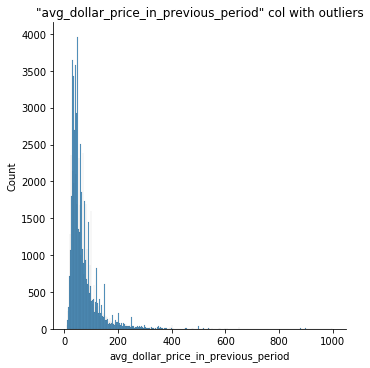

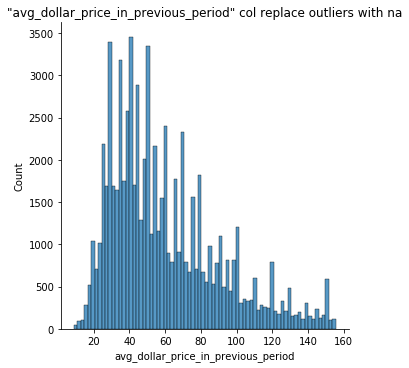

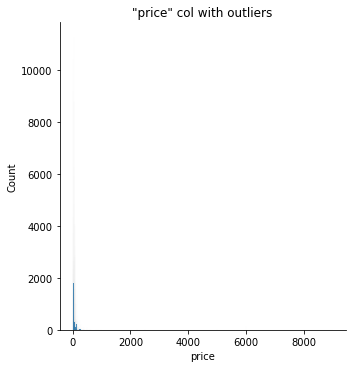

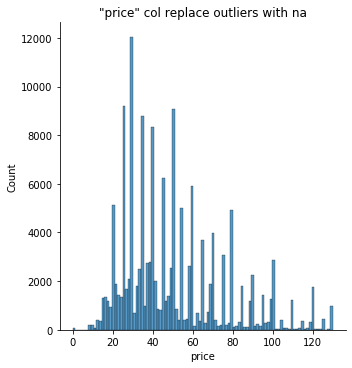

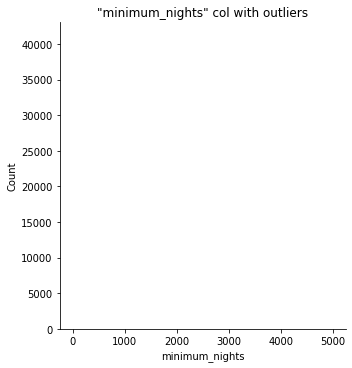

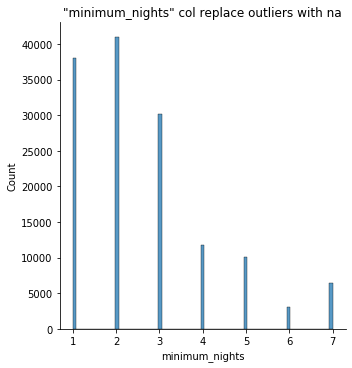

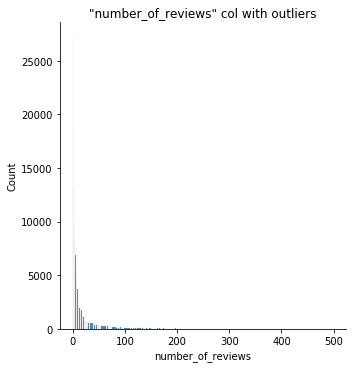

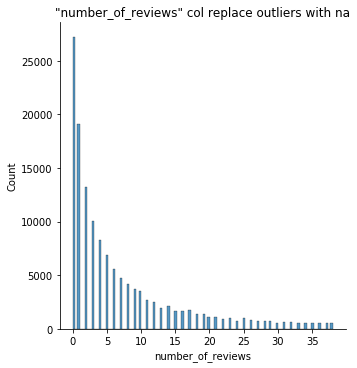

In [34]:
seaborn_displot_replace_col_with_outliers(_df_orig=df, 
                                          _df_all_outliers_na=df_all_outliers_na, 
                                          _cols_list=cols_replace_outliers_with_none[0:4])

<Figure size 432x288 with 0 Axes>

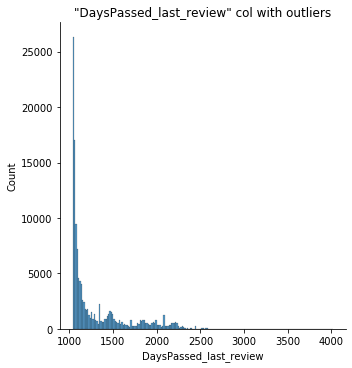

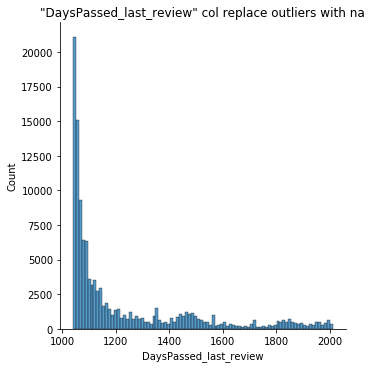

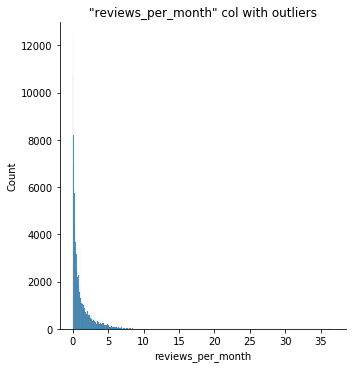

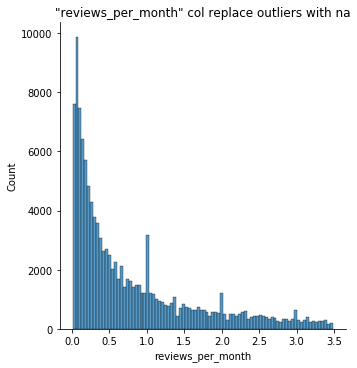

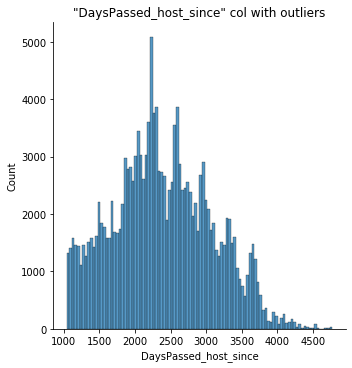

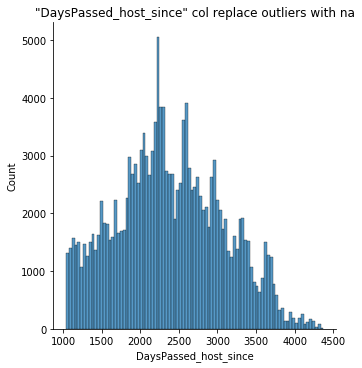

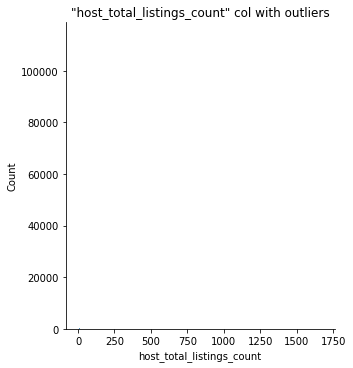

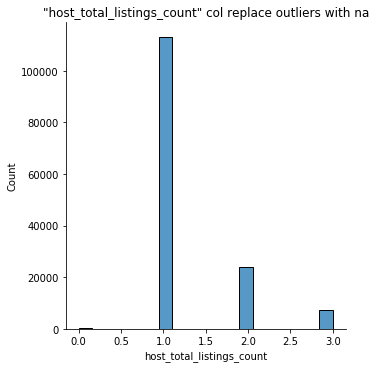

In [35]:
seaborn_displot_replace_col_with_outliers(_df_orig=df,
                                          _df_all_outliers_na=df_all_outliers_na, 
                                          _cols_list=cols_replace_outliers_with_none[4:8])

<Figure size 432x288 with 0 Axes>

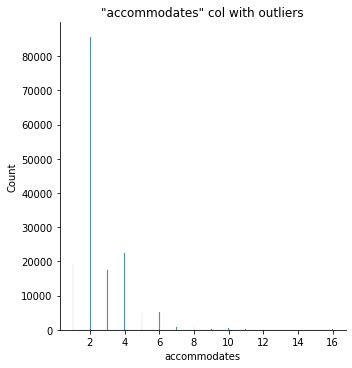

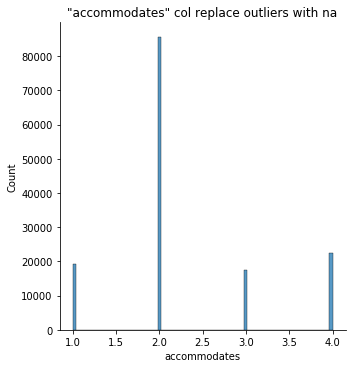

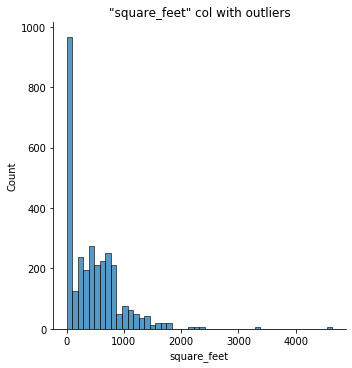

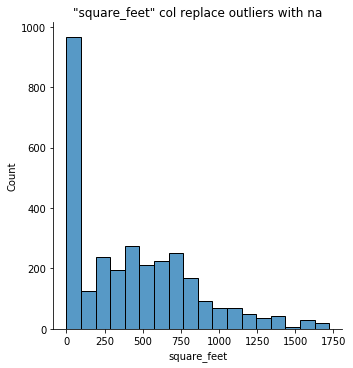

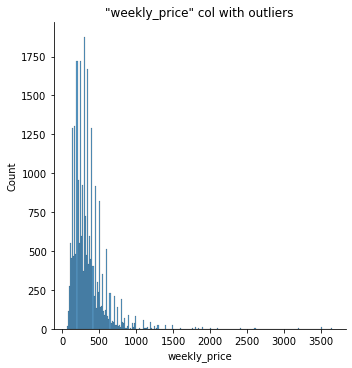

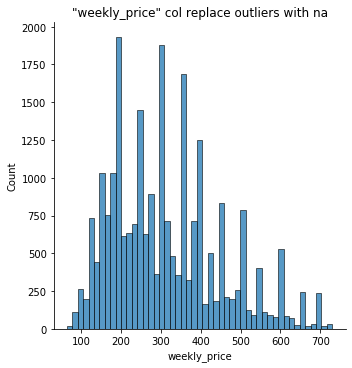

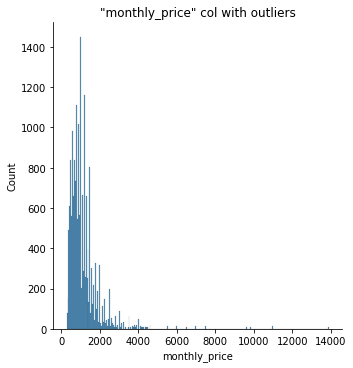

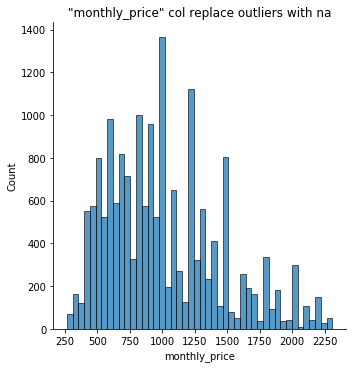

In [36]:
seaborn_displot_replace_col_with_outliers(_df_orig=df, 
                                          _df_all_outliers_na=df_all_outliers_na, 
                                          _cols_list=cols_replace_outliers_with_none[8:12])

<Figure size 432x288 with 0 Axes>

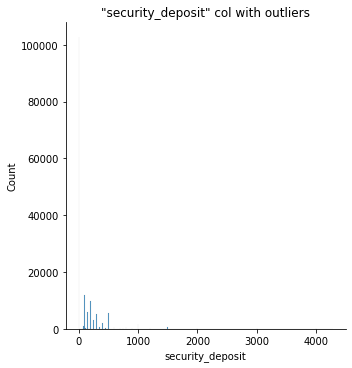

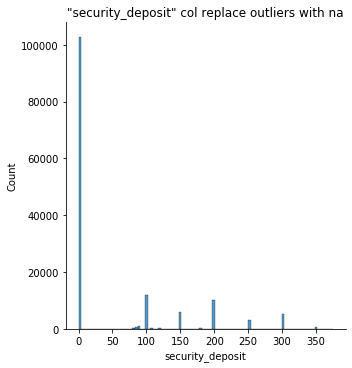

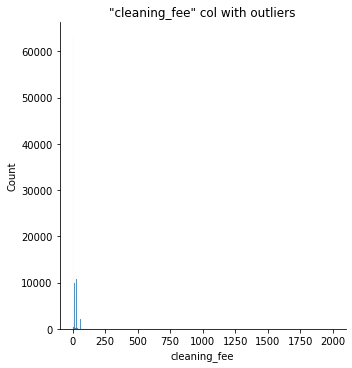

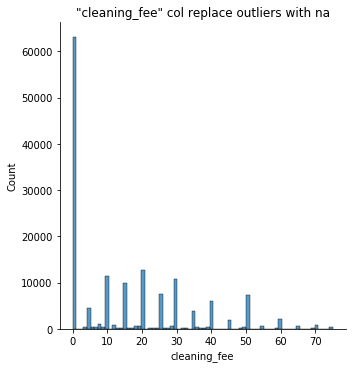

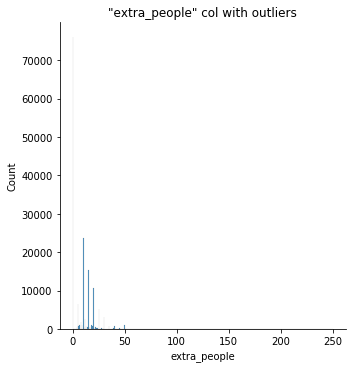

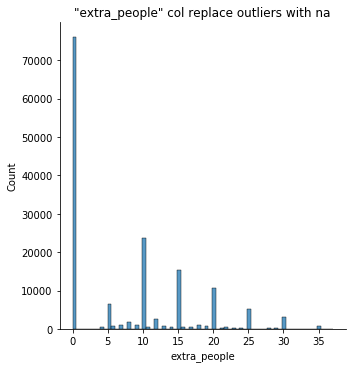

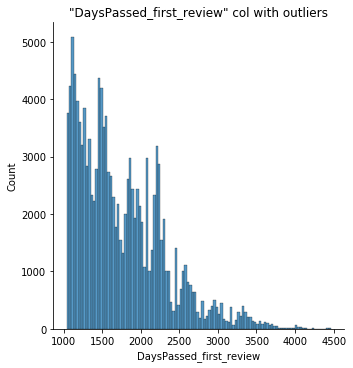

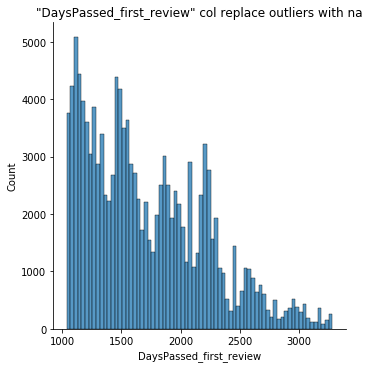

In [37]:
seaborn_displot_replace_col_with_outliers(_df_orig=df, 
                                          _df_all_outliers_na=df_all_outliers_na, 
                                          _cols_list=cols_replace_outliers_with_none[12:16])

<Figure size 432x288 with 0 Axes>

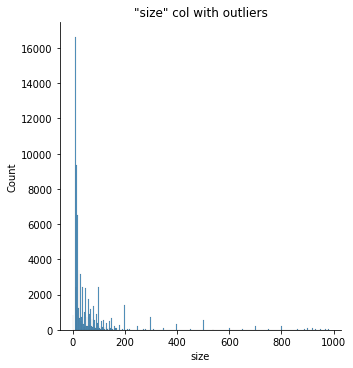

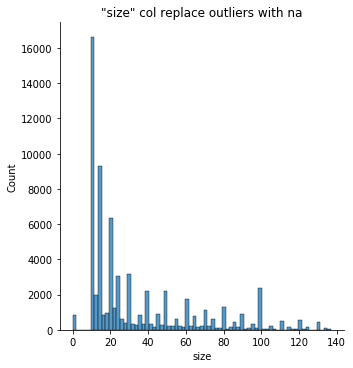

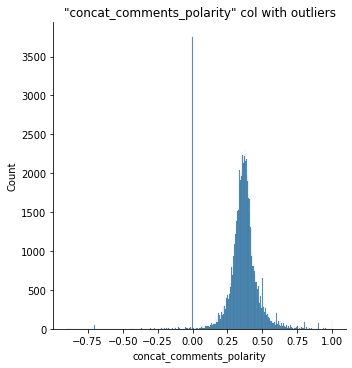

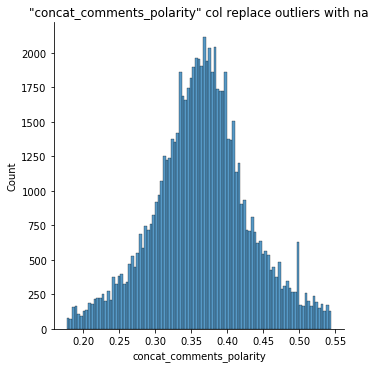

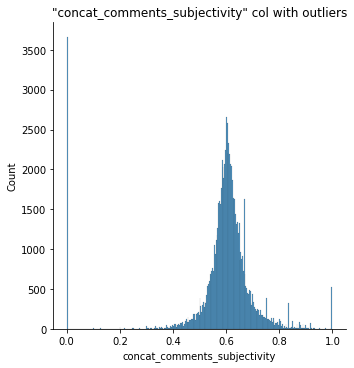

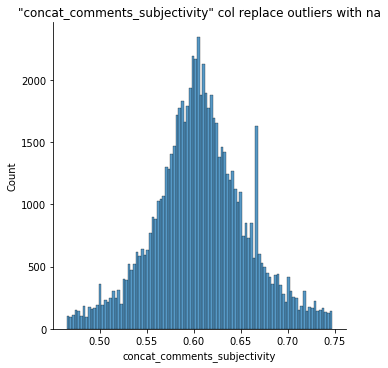

In [38]:
seaborn_displot_replace_col_with_outliers(_df_orig=df, 
                                          _df_all_outliers_na=df_all_outliers_na, 
                                          _cols_list=cols_replace_outliers_with_none[16:20])

### No removing outliers columns

In [39]:
# all rows in df_drop_outliers which have "No". This are cols in flat table that outliers are not replaced with None.
# Perform a data transformation or make the variable categorical and thus divide it into groups 
#that one of which will be "missing" or use models to predict the missing variables
cols_keep_outliers = get_outliers_colums_to_keep(_df_drop_outliers=df_drop_outliers)
if 'booked_up_target' in cols_keep_outliers:
    cols_keep_outliers.remove('booked_up_target')


cols_keep_outliers

['target_avg_dollar_price_in_period',
 'calculated_host_listings_count',
 'bedrooms',
 'guests_included']

In [40]:
def compare_col_with_transform_of_keep_outliers_with_math_func(_df: pd.DataFrame, _col_name: str, _col_transform_name: str):
    """
    creating a function that prints the description and the distribution before and
    after the transformation.
    """
    
    print(f'{_col_name} describe', _df[_col_name].describe())
    sns.set_theme(style="whitegrid")
    plt.figure(figsize = (5,5))
    sns.displot(data=df , x=_col_name).set(title= f'"{_col_name}" col')

    plt.tight_layout()
    plt.show()
    
    print(f'{_col_transform_name} describe', _df[_col_transform_name].describe())
    sns.set_theme(style="whitegrid")
    plt.figure(figsize = (5,5))
    sns.displot(data=df , x=_col_transform_name).set(title= f'"{_col_transform_name}" col')

    plt.tight_layout()
    plt.show()
    

#### target_avg_dollar_price_in_period
Checking transformation of log

target_avg_dollar_price_in_period describe count    43919.000000
mean        79.516889
std         72.304940
min          9.000000
25%         40.000000
50%         60.000000
75%         92.801500
max        999.000000
Name: target_avg_dollar_price_in_period, dtype: float64


<Figure size 360x360 with 0 Axes>

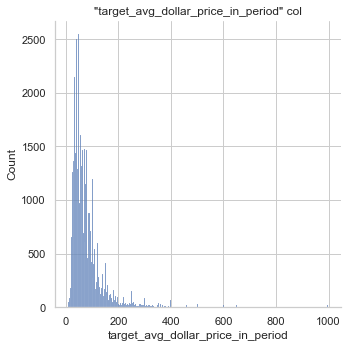

log_target_avg_dollar_price_in_period describe count    43919.000000
mean         4.144379
std          0.635910
min          2.197225
25%          3.688879
50%          4.094345
75%          4.530463
max          6.906755
Name: log_target_avg_dollar_price_in_period, dtype: float64


<Figure size 360x360 with 0 Axes>

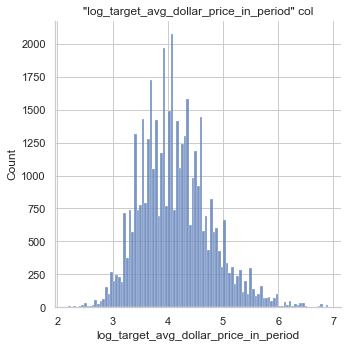

In [41]:
df['log_target_avg_dollar_price_in_period'] =  np.log(df['target_avg_dollar_price_in_period'])

compare_col_with_transform_of_keep_outliers_with_math_func(_df=df, 
                                                           _col_name='target_avg_dollar_price_in_period',
                                                          _col_transform_name='log_target_avg_dollar_price_in_period')


log of target_avg_dollar_price_in_period has normal distributaion --> using the log of this column

#### calculated_host_listings_count
Checking transformation of log

calculated_host_listings_count describe count    157864.000000
mean          1.918233
std           3.667187
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          45.000000
Name: calculated_host_listings_count, dtype: float64


<Figure size 360x360 with 0 Axes>

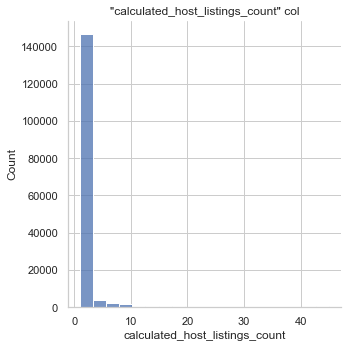

log_calculated_host_listings_count describe count    157864.000000
mean          0.281526
std           0.620869
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.806662
Name: log_calculated_host_listings_count, dtype: float64


<Figure size 360x360 with 0 Axes>

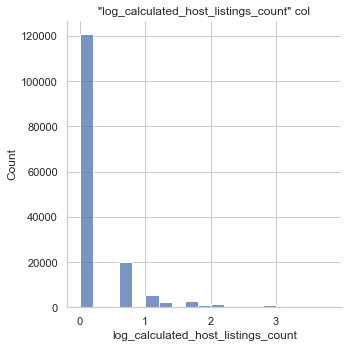

In [42]:
df['log_calculated_host_listings_count'] =  np.log(df['calculated_host_listings_count'])

compare_col_with_transform_of_keep_outliers_with_math_func(_df=df, 
                                                           _col_name='calculated_host_listings_count',
                                                          _col_transform_name='log_calculated_host_listings_count')

log of calculated_host_listings_count not seems to contribute --> we will not use it. 

In [43]:
if 'log_calculated_host_listings_count' in df.columns:
    df.drop('log_calculated_host_listings_count',axis=1, inplace=True)

#### calculated_host_listings_count
Checking transformation of sqrt 

calculated_host_listings_count describe count    157864.000000
mean          1.918233
std           3.667187
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          45.000000
Name: calculated_host_listings_count, dtype: float64


<Figure size 360x360 with 0 Axes>

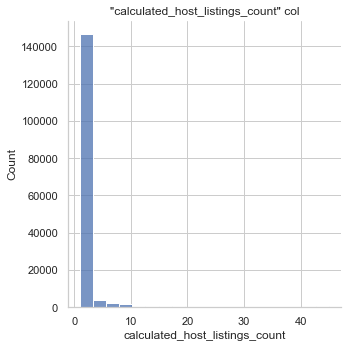

sqrt_calculated_host_listings_count describe count    157864.000000
mean          1.229624
std           0.637385
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.708204
Name: sqrt_calculated_host_listings_count, dtype: float64


<Figure size 360x360 with 0 Axes>

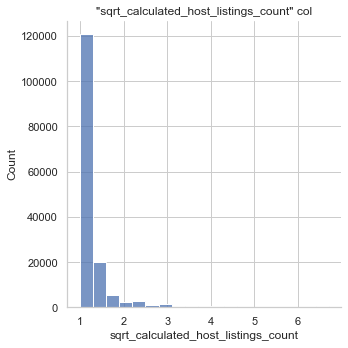

In [44]:
df['sqrt_calculated_host_listings_count'] =  np.sqrt(df['calculated_host_listings_count'])

compare_col_with_transform_of_keep_outliers_with_math_func(_df=df, 
                                                           _col_name='calculated_host_listings_count',
                                                          _col_transform_name='sqrt_calculated_host_listings_count')

sqrt of calculated_host_listings_count has more shrinked distributaion --> using the sqrt of this column

calculated_host_listings_count describe count    157864.000000
mean          1.918233
std           3.667187
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          45.000000
Name: calculated_host_listings_count, dtype: float64


<Figure size 360x360 with 0 Axes>

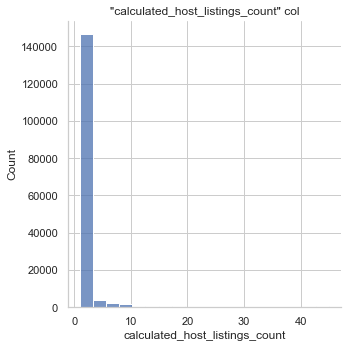

sigmoid_calculated_host_listings_count describe count    157864.000000
mean          0.777140
std           0.086731
min           0.731059
25%           0.731059
50%           0.731059
75%           0.731059
max           1.000000
Name: sigmoid_calculated_host_listings_count, dtype: float64


<Figure size 360x360 with 0 Axes>

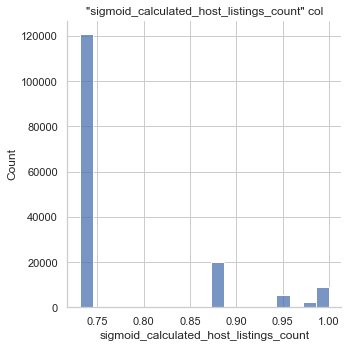

In [45]:
df['sigmoid_calculated_host_listings_count'] =  1/(1 + np.exp(-df['calculated_host_listings_count']))

compare_col_with_transform_of_keep_outliers_with_math_func(_df=df, 
                                                           _col_name='calculated_host_listings_count',
                                                          _col_transform_name='sigmoid_calculated_host_listings_count')

#### bedrooms
Checking transformation of sqrt (values can be zero so I didnot use log)

bedrooms describe count    157738.000000
mean          1.161134
std           0.646144
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          12.000000
Name: bedrooms, dtype: float64


<Figure size 360x360 with 0 Axes>

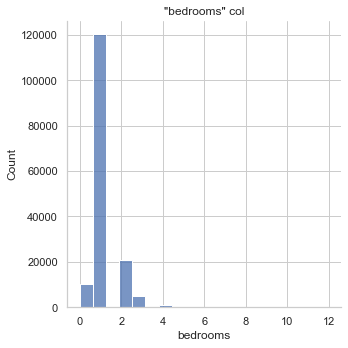

sqrt_bedrooms describe count    157738.000000
mean          1.022283
std           0.340694
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.464102
Name: sqrt_bedrooms, dtype: float64


<Figure size 360x360 with 0 Axes>

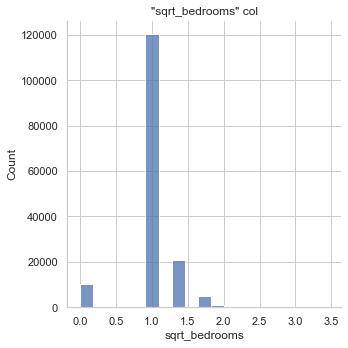

In [46]:
df['sqrt_bedrooms'] =  np.sqrt(df['bedrooms'])
compare_col_with_transform_of_keep_outliers_with_math_func(_df=df, 
                                                           _col_name='bedrooms',
                                                          _col_transform_name='sqrt_bedrooms')

sqrt of bedrooms has shrink distributaion --> using the sqrt of this column

#### guests_included
Checking transformation of sqrt guests_included

guests_included describe count    157864.000000
mean          1.332121
std           0.835018
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: guests_included, dtype: float64


<Figure size 360x360 with 0 Axes>

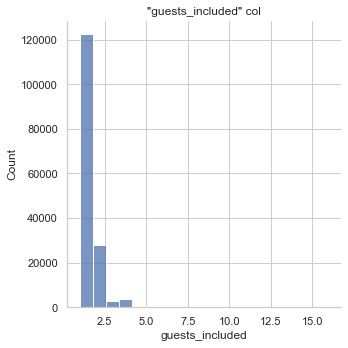

sqrt_guests_included describe count    157864.000000
mean          1.122827
std           0.267173
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: sqrt_guests_included, dtype: float64


<Figure size 360x360 with 0 Axes>

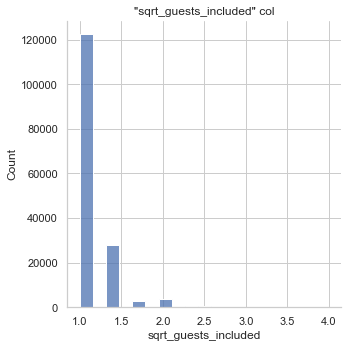

In [47]:
df['sqrt_guests_included'] =  np.sqrt(df['guests_included'])
compare_col_with_transform_of_keep_outliers_with_math_func(_df=df, 
                                                           _col_name='guests_included',
                                                          _col_transform_name='sqrt_guests_included')

sqrt of guests_included has shrink distributaion --> using the sqrt of this column

# Missing values

In this section, we will explore which variables have missing values and their percentage. 

We will also explore how the missing values are distributed along the dataset.

The methodology of the treatment in missing values depends on the mechanism of missing generation for each variable.
For each variable we have to decide the correct method to be applied.

The following cells appear in the EDA also, but after transform outliers to None we have more missing values/None.


number of columns that have Nulls:  26


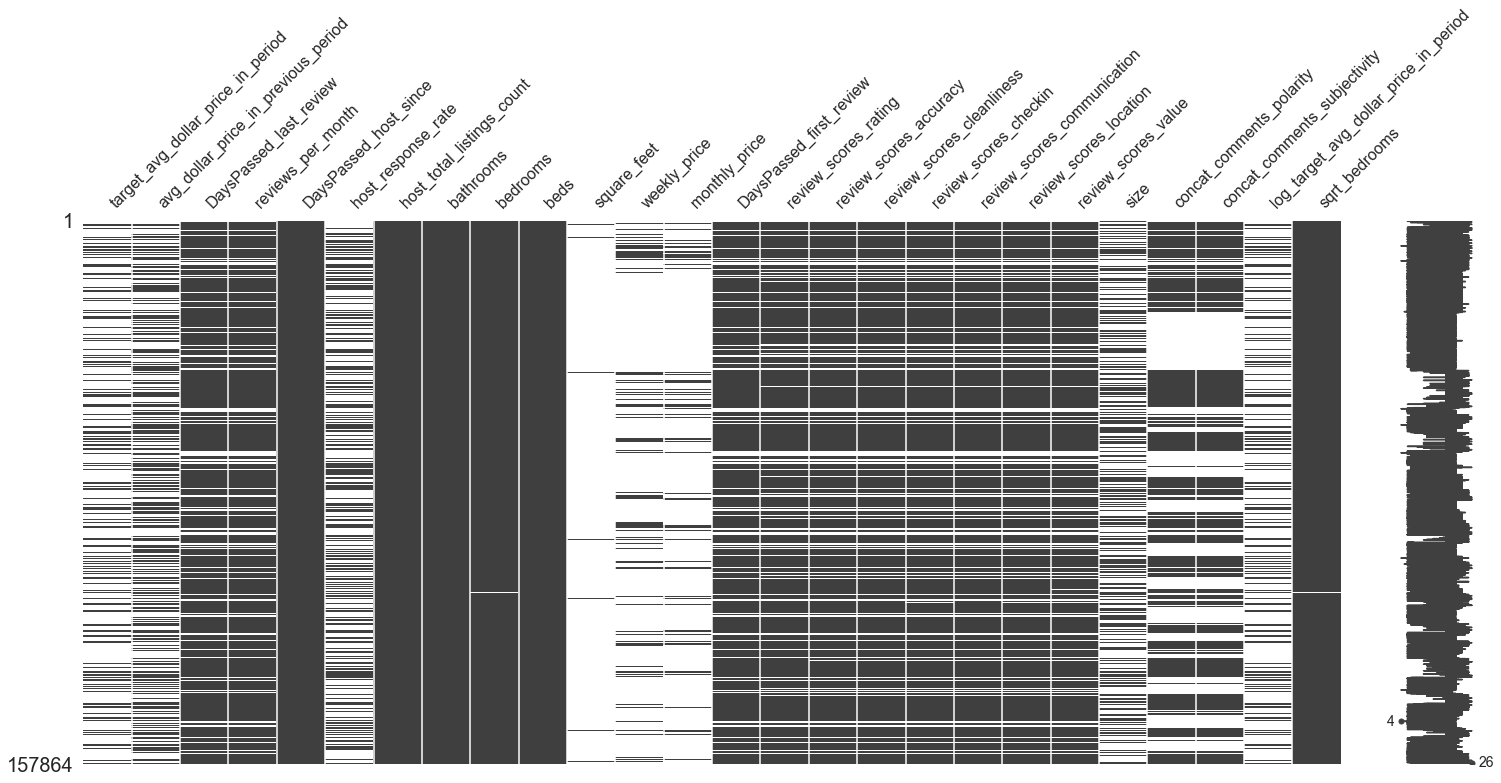

In [48]:
# Getting columns that have Null(s)
missing_data_cols_names_list = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missing_data_cols_names_list])
print("number of columns that have Nulls: ", len(missing_data_cols_names_list))

selecting columns in indexes [ 0 :  15 ]
selecting columns in indexes [ 15 :  26 ]


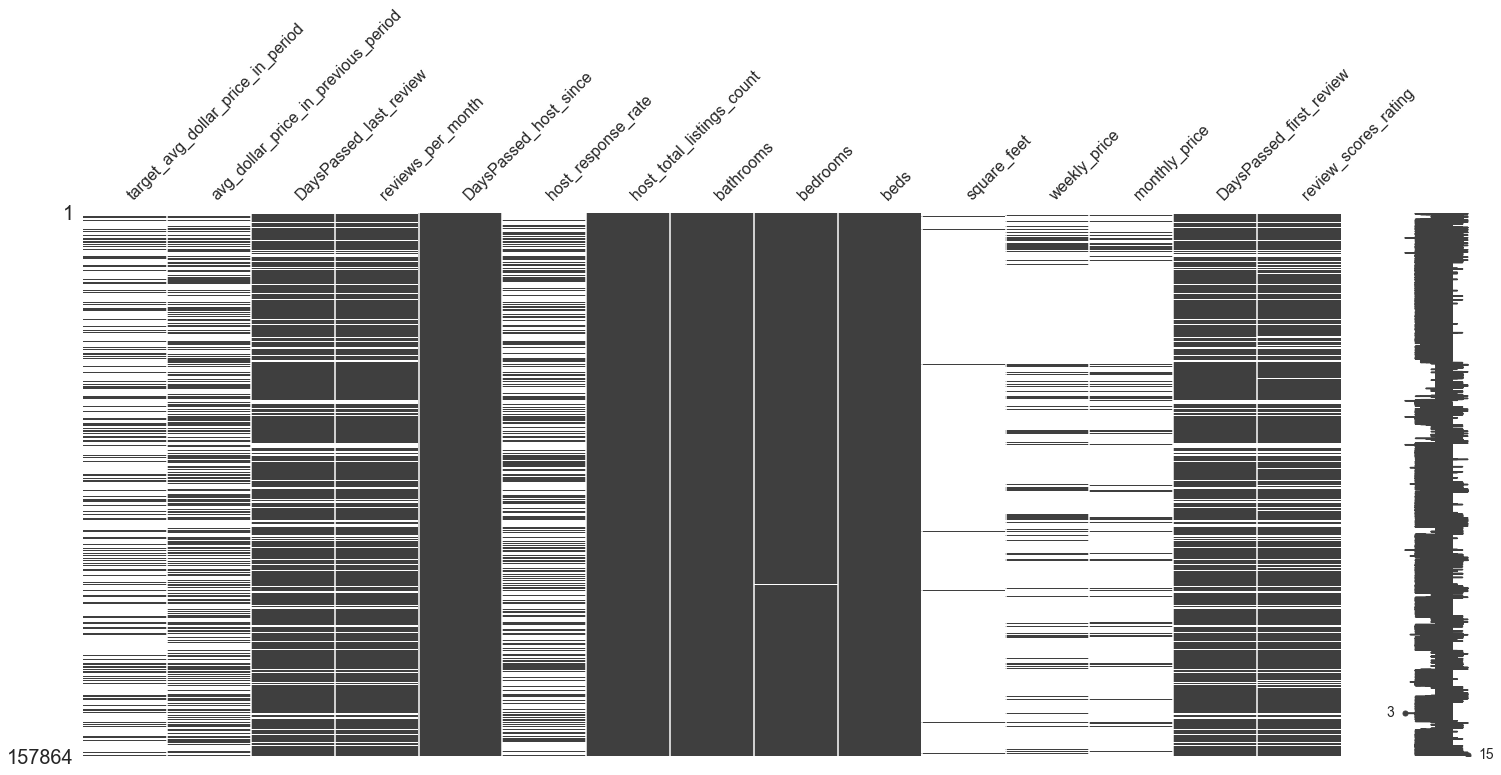

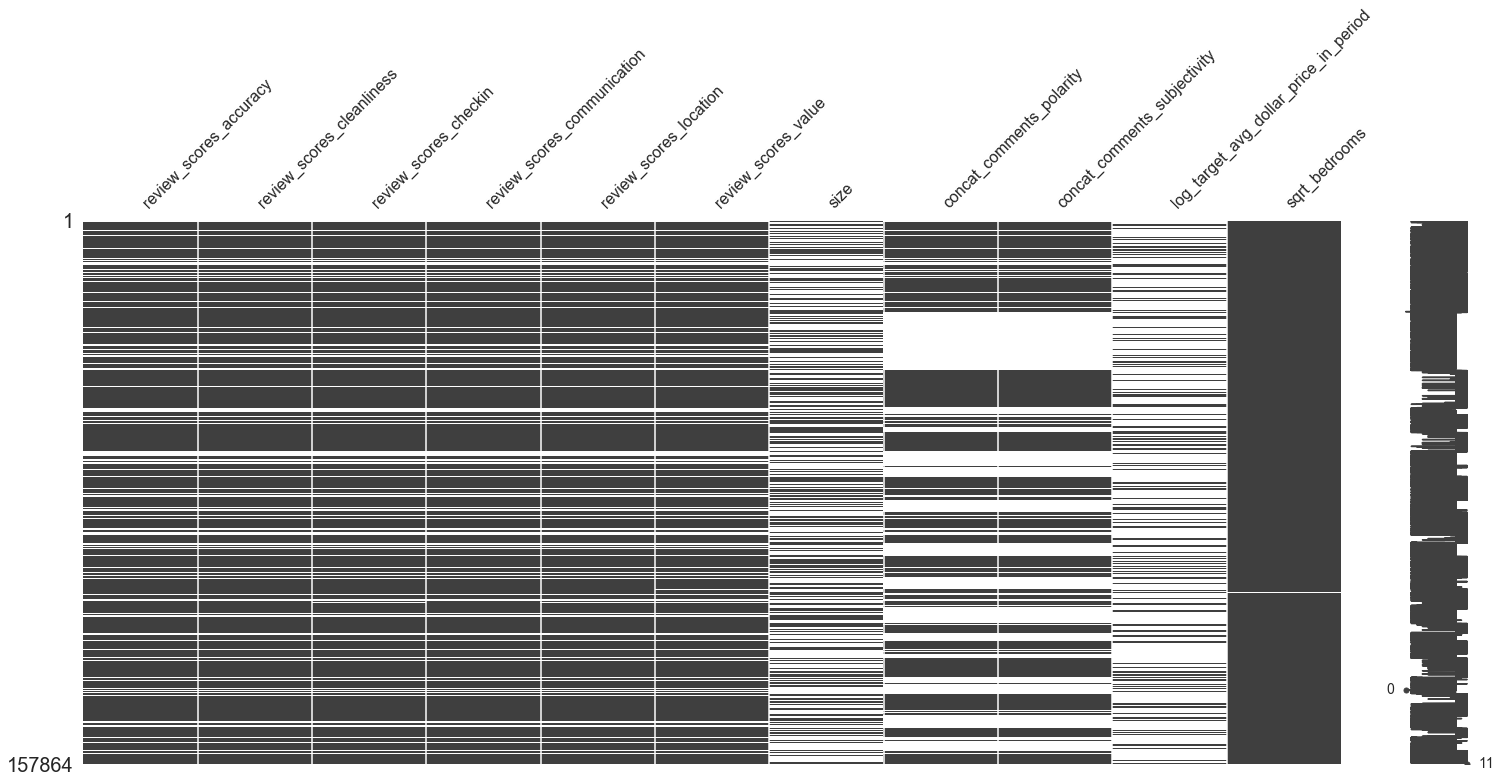

In [49]:
# As ploting above, becuase "missing_data_cols_names_list" has many columns 
# and I can't see columns names I split to chucnk of columns only for view the column names.
n=15 # max number of columns in each chunk
for i in range(0, len(missing_data_cols_names_list), n):
    start_chunk_index = i
    end_chunk_index = i+n if i+n < len(missing_data_cols_names_list) else len(missing_data_cols_names_list)
    print("selecting columns in indexes [", start_chunk_index, ": ", end_chunk_index, "]")
    msno.matrix(df[missing_data_cols_names_list[i:i+n]])
    

In [50]:
print(df.isnull().sum())

target_num_of_day_in_period                    0
target_num_of_booked_days                      0
booked_up_target                               0
num_of_day_in_previous_period                  0
num_of_booked_days_in_previous_period          0
target_avg_dollar_price_in_period         113945
occupancy_last_period                          0
avg_dollar_price_in_previous_period        79553
price                                          0
minimum_nights                                 0
number_of_reviews                              0
DaysPassed_last_review                     27356
reviews_per_month                          27398
calculated_host_listings_count                 0
availability_365                               0
DaysPassed_host_since                        182
host_response_rate                         90265
host_total_listings_count                    182
accommodates                                   0
bathrooms                                    224
bedrooms            

In [51]:
def get_rate_table_of_na_in_columns(_df):
    """
    Describe the number of na each column and the rate/precenatge of na in each column. 
    """
    col_list = _df.columns
    df_sum_of_na =  _df.isna().sum() # pandas.core.series.Series
    num_of_records = len(_df)
    results = []
    for col in col_list:
        na_count = df_sum_of_na[col]
        res = {"col_name_in_flat_table": col, "na.count": na_count, "rate": na_count/num_of_records*100.0}
        results.append(res)
    return pd.DataFrame(results).sort_values("rate", ascending=False)

In [52]:
get_rate_table_of_na_in_columns(df)

,col_name_in_flat_table,na.count,rate
22,square_feet,154742,98.022348
24,monthly_price,139251,88.209471
23,weekly_price,132097,83.677723
5,target_avg_dollar_price_in_period,113945,72.179218
44,log_target_avg_dollar_price_in_period,113945,72.179218
16,host_response_rate,90265,57.178964
41,size,82579,52.310216
7,avg_dollar_price_in_previous_period,79553,50.393377
42,concat_comments_polarity,72709,46.057999
43,concat_comments_subjectivity,72709,46.057999


### checking the number of NA in rows, and dropping rows with NA>60%

Before treating each column, I will check if there are rows with more than 60% na and drop them.

In [53]:
def get_rate_table_of_na_in_rows(df_orig):
    """
    df is orig dataframe before adding Accessory Columns
    """
   
    num_of_columns = len(df_orig.columns)
    # create datafame with index column and num_of_nan_in_row. num_of_nan_in_row contains the numnber of na in a row.
    # axis=1 for sum the number of nas in row
    # to_frame convert Series to DataFrame 
    df_num_of_nans_in_rows = df_orig.isna().sum(axis = 1).to_frame(name="num_of_nan_in_row")
    # merge by index with the flat table
    df_orig_with_nans =  df_orig.merge(df_num_of_nans_in_rows, left_index=True, right_index=True)
    # row_nan_rate is num_of_nan_in_row divided by the num_of_columns
    df_orig_with_nans["row_nan_rate"] = df_orig_with_nans["num_of_nan_in_row"].apply(lambda x: x/num_of_columns*100.0)
    return df_orig_with_nans

def drop_rows_by_perc_of_nan(df_orig, threshold_perc=60):
    """
    function that drop rows with more than 60% na (threshold percentage)
    df is orig dataframe before adding Accessory Columns
    """
    df_orig_with_nan = get_rate_table_of_na_in_rows(df_orig)
    return df_orig[df_orig_with_nan['row_nan_rate']<threshold_perc]

In [54]:
# dropping rows from flat table which have more than 60% None/na (after transform ouliers to na)
df_clean1 = drop_rows_by_perc_of_nan(df, threshold_perc=60)
df_clean1.head(3)

,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,target_avg_dollar_price_in_period,occupancy_last_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,DaysPassed_host_since,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,DaysPassed_first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,size,concat_comments_polarity,concat_comments_subjectivity,log_target_avg_dollar_price_in_period,sqrt_calculated_host_listings_count,sigmoid_calculated_host_listings_count,sqrt_bedrooms,sqrt_guests_included
0,92,92,1,206,180,NaN,0.87,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,NaN,1.0,0.731059,1.0,1.0
1,92,92,1,236,210,NaN,0.89,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,NaN,1.0,0.731059,1.0,1.0
2,98,98,1,267,241,NaN,0.90,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,NaN,1.0,0.731059,1.0,1.0


In [55]:
# after removing rows that have more than 60% none, print again the number of None/na in each column
get_rate_table_of_na_in_columns(df_clean1)

,col_name_in_flat_table,na.count,rate
22,square_feet,154742,98.022348
24,monthly_price,139251,88.209471
23,weekly_price,132097,83.677723
5,target_avg_dollar_price_in_period,113945,72.179218
44,log_target_avg_dollar_price_in_period,113945,72.179218
16,host_response_rate,90265,57.178964
41,size,82579,52.310216
7,avg_dollar_price_in_previous_period,79553,50.393377
42,concat_comments_polarity,72709,46.057999
43,concat_comments_subjectivity,72709,46.057999


### checking the number of NA in columns

In this section, we will explore which variables have missing values and their percentage. 

The methodology of the treatment in missing values:
1. If the percentages of na are greater than 70% -> dropping the column.
2. If the percentages of na between 40%-70% -> transforming the variable categorical.
3. If the percentages of na are lower than 40% -> depends on the mechanism of missing generation for each variable.
For each variable, we have to decide the correct method to be applied.
If the mechanism of missing is MNAR -> There is an explanation of why the value is missing. In this case, we can 
transform the variable categorical or drop the column, we can not do imputation.
Otherwise, if the missing mechanism is MCAR or MAR, we can use imputation techniques.



In [56]:
# Get list of colums names by the rate of na/None in dataframe

def get_cols_list_with_na_in_range(df_orig: pd.DataFrame, low_threshold: int, high_threshold: int):
    """
    low_threshold and high_threshold are the in range of 0 to 100
    """
    df_col_na_rate = get_rate_table_of_na_in_columns(df_orig) # "col_name_in_flat_table", "na.count", "rate"
    
    df_col_na_rate_after_filter = df_col_na_rate[(df_col_na_rate['rate'] >= low_threshold) &  (df_col_na_rate['rate'] <= high_threshold)] # "col_name_in_flat_table", "na.count", "rate"
    return df_col_na_rate_after_filter['col_name_in_flat_table'].to_list()

In [57]:
#  percentages of the na are greater than 70% -> dropping the column.

cols_with_more_than_70_na = get_cols_list_with_na_in_range(df_clean1, 70, 100)

print(f"dropping columns {cols_with_more_than_70_na} which have more than 70% of none/na ")
df_clean2 = df_clean1.drop(cols_with_more_than_70_na,axis =1, inplace=False)
print("number of columns *before* dropping columns with more than 70% na: ", len(df_clean1.columns))
print("number of columns *after*  dropping columns with more than 70% na: ", len(df_clean2.columns))

dropping columns ['square_feet', 'monthly_price', 'weekly_price', 'target_avg_dollar_price_in_period', 'log_target_avg_dollar_price_in_period'] which have more than 70% of none/na 
number of columns *before* dropping columns with more than 70% na:  49
number of columns *after*  dropping columns with more than 70% na:  44


In [58]:
get_rate_table_of_na_in_columns(df_clean2)

,col_name_in_flat_table,na.count,rate
15,host_response_rate,90265,57.178964
37,size,82579,52.310216
6,avg_dollar_price_in_previous_period,79553,50.393377
39,concat_comments_subjectivity,72709,46.057999
38,concat_comments_polarity,72709,46.057999
36,review_scores_value,31045,19.665662
33,review_scores_checkin,31024,19.652359
35,review_scores_location,31017,19.647925
34,review_scores_communication,30926,19.590280
31,review_scores_accuracy,30898,19.572543


In [59]:
df_clean2['host_response_rate'].describe()

count    67599.000000
mean         0.918985
std          0.193752
min          0.000000
25%          0.950000
50%          1.000000
75%          1.000000
max          1.000000
Name: host_response_rate, dtype: float64

In [60]:
# The percentages of na between 40%-70% -> transforming the variable categorical.

CATEGORY_SUFFIX = "_cat"

def transform_numeric_to_category_col(_df: pd.DataFrame, _col_name: str, drop_orig_col: bool = False) -> pd.DataFrame:
    """
    Add new column _col_name+"_cat" which split numeric col to category col by percneatge 
    """
    df_col_describe = _df[_col_name].describe()
    threshold_25 = df_col_describe['25%']
    threshold_50 = df_col_describe['50%']
    threshold_75 = df_col_describe['75%']
    
    def get_category(row_value):
        if pd.isna(row_value):
            return _col_name + "_missing"
        elif row_value <= threshold_25:
            return _col_name + "_0%_to_25%"
        elif row_value <= threshold_50:
            return _col_name + "_25%_to_50%"
        elif row_value <= threshold_75:
            return _col_name + "_50%_to_75%"
        else:
            return _col_name + "_75%_to_100%"
    
    target_col_name = _col_name+ CATEGORY_SUFFIX
    _df[target_col_name] = _df[_col_name].apply(get_category)
    
    if drop_orig_col == True:
         _df.drop([_col_name], axis=1, inplace=True)
            
    print(f'add new col: "{target_col_name}" base on "{_col_name}"')
    return _df


######################################################################
# Testing
######################################################################
df_test = pd.DataFrame(list(range(1, 5))+ [None], columns=['my_numeric_col'])
print("df_test: ")
display(df_test)
print("df_test.describe(): ")
display(df_test.describe())
print("results of transform_numeric_to_category_col:")
transform_numeric_to_category_col(df_test,'my_numeric_col' )

df_test: 


,my_numeric_col
0,1.0
1,2.0
2,3.0
3,4.0
4,NaN


df_test.describe(): 


,my_numeric_col
count,4.000000
mean,2.500000
std,1.290994
min,1.000000
25%,1.750000
50%,2.500000
75%,3.250000
max,4.000000


results of transform_numeric_to_category_col:
add new col: "my_numeric_col_cat" base on "my_numeric_col"


,my_numeric_col,my_numeric_col_cat
0,1.0,my_numeric_col_0%_to_25%
1,2.0,my_numeric_col_25%_to_50%
2,3.0,my_numeric_col_50%_to_75%
3,4.0,my_numeric_col_75%_to_100%
4,NaN,my_numeric_col_missing


In [61]:
df_clean2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157864 entries, 0 to 157863
Data columns (total 44 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   target_num_of_day_in_period             157864 non-null  int64  
 1   target_num_of_booked_days               157864 non-null  int64  
 2   booked_up_target                        157864 non-null  int64  
 3   num_of_day_in_previous_period           157864 non-null  int64  
 4   num_of_booked_days_in_previous_period   157864 non-null  int64  
 5   occupancy_last_period                   157864 non-null  float64
 6   avg_dollar_price_in_previous_period     78311 non-null   float64
 7   price                                   157864 non-null  float64
 8   minimum_nights                          157864 non-null  float64
 9   number_of_reviews                       157864 non-null  float64
 10  DaysPassed_last_review                  1305

In [62]:
# # The percentages of na between 40%-70% -> transforming the variable categorical.


cols_with_na_rate_40_70 = get_cols_list_with_na_in_range(df_clean2, 40, 70)
print("columns that have none between 40% to 70%:", cols_with_na_rate_40_70)

df_clean3 = df_clean2.copy()
for col in cols_with_na_rate_40_70:
    df_clean3 = transform_numeric_to_category_col(_df = df_clean3, _col_name=col)
    

display(df_clean3.head(3))

columns that have none between 40% to 70%: ['host_response_rate', 'size', 'avg_dollar_price_in_previous_period', 'concat_comments_subjectivity', 'concat_comments_polarity']
add new col: "host_response_rate_cat" base on "host_response_rate"
add new col: "size_cat" base on "size"
add new col: "avg_dollar_price_in_previous_period_cat" base on "avg_dollar_price_in_previous_period"
add new col: "concat_comments_subjectivity_cat" base on "concat_comments_subjectivity"
add new col: "concat_comments_polarity_cat" base on "concat_comments_polarity"


,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,DaysPassed_host_since,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,DaysPassed_first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,size,concat_comments_polarity,concat_comments_subjectivity,sqrt_calculated_host_listings_count,sigmoid_calculated_host_listings_count,sqrt_bedrooms,sqrt_guests_included,host_response_rate_cat,size_cat,avg_dollar_price_in_previous_period_cat,concat_comments_subjectivity_cat,concat_comments_polarity_cat
0,92,92,1,206,180,0.87,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,1.0,0.731059,1.0,1.0,host_response_rate_25%_to_50%,size_25%_to_50%,avg_dollar_price_in_previous_period_25%_to_50%,concat_comments_subjectivity_50%_to_75%,concat_comments_polarity_50%_to_75%
1,92,92,1,236,210,0.89,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,1.0,0.731059,1.0,1.0,host_response_rate_25%_to_50%,size_25%_to_50%,avg_dollar_price_in_previous_period_25%_to_50%,concat_comments_subjectivity_50%_to_75%,concat_comments_polarity_50%_to_75%
2,98,98,1,267,241,0.90,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,1.0,0.731059,1.0,1.0,host_response_rate_25%_to_50%,size_25%_to_50%,avg_dollar_price_in_previous_period_25%_to_50%,concat_comments_subjectivity_50%_to_75%,concat_comments_polarity_50%_to_75%


'host_response_rate', 'size', 'avg_dollar_price_in_previous_period', 'concat_comments_subjectivity', 'concat_comments_polarity' tarnsformed to 'host_response_rate_cat', 'size_cat', 'avg_dollar_price_in_previous_period_cat', 'concat_comments_subjectivity_cat', 'concat_comments_polarity_cat'
Keeping the original columns for debuging by need (not use them in the model)

In [63]:
# TODO 
get_rate_table_of_na_in_columns(df_clean3)

,col_name_in_flat_table,na.count,rate
15,host_response_rate,90265,57.178964
37,size,82579,52.310216
6,avg_dollar_price_in_previous_period,79553,50.393377
39,concat_comments_subjectivity,72709,46.057999
38,concat_comments_polarity,72709,46.057999
36,review_scores_value,31045,19.665662
33,review_scores_checkin,31024,19.652359
35,review_scores_location,31017,19.647925
34,review_scores_communication,30926,19.590280
31,review_scores_accuracy,30898,19.572543


###  Making desicion about the mechanism of missingness using the Kolmogorov-Smirnov test

The percentages of na are lower than 40% -> depends on the mechanism of missing generation for each variable.
For each variable, we have to decide the correct method to be applied.
If the mechanism of missing is MNAR -> There is an explanation of why the value is missing. In this case, we can 
transform the variable categorical or drop the column, we can not do imputation.
Otherwise, if the missing mechanism is MCAR or MAR, we can use imputation techniques.

In [64]:
# The percentages of na are lower than 40%
df_missing = get_rate_table_of_na_in_columns(df_clean3)
col_list = get_cols_list_with_na_in_range(df_orig =df_clean3 , low_threshold=0.001, high_threshold=39.999)
df_cols = pd.DataFrame({"col_name_in_flat_table_2": col_list})
df_cols['join_key'] = 1
df_missing['join_key'] = 1
print(df_missing)

                     col_name_in_flat_table  na.count       rate  join_key
15                       host_response_rate     90265  57.178964         1
37                                     size     82579  52.310216         1
6       avg_dollar_price_in_previous_period     79553  50.393377         1
39             concat_comments_subjectivity     72709  46.057999         1
38                 concat_comments_polarity     72709  46.057999         1
36                      review_scores_value     31045  19.665662         1
33                    review_scores_checkin     31024  19.652359         1
35                   review_scores_location     31017  19.647925         1
34              review_scores_communication     30926  19.590280         1
31                   review_scores_accuracy     30898  19.572543         1
32                review_scores_cleanliness     30877  19.559241         1
30                     review_scores_rating     30723  19.461689         1
11                       

In [65]:
# Kolmogorov-Smirnov test

def get_ks_2samp_df_on_na(_df_src, _cols_list_1,_cols_list_2, pvalue_distribution_changed = 0.05):
    results = []
    for col_1 in _cols_list_1:
        for col_2 in _cols_list_2:
            if col_1 == col_2:
                continue
            #print("col_1:", col_1, "col_2:", col_2)
            statistic, pvalue = ks_2samp(_df_src[col_1], _df_src[col_2],mode="asymp")
            result = {"col_name_in_flat_table_1": col_1, 
                      "col_name_in_flat_table_2": col_2,
                      "statistic":statistic, 
                      "pvalue": pvalue,
                      "distribution_changed": "+" if pvalue < pvalue_distribution_changed else "-"}
            results.append(result)
    return pd.DataFrame(results)

col_list_1 = get_cols_list_with_na_in_range(df_orig =df_clean3 , low_threshold=0.01, high_threshold=39.9)
col_list_2 = [col for col in df_clean3.columns if col.endswith(CATEGORY_SUFFIX) == False]

df_ks_2samp_df_on_na = get_ks_2samp_df_on_na(df_clean3, col_list_1, col_list_2)

df_ks_2samp_df_on_na

,col_name_in_flat_table_1,col_name_in_flat_table_2,statistic,pvalue,distribution_changed
0,review_scores_value,target_num_of_day_in_period,0.803343,0.000000e+00,+
1,review_scores_value,target_num_of_booked_days,0.623967,0.000000e+00,+
2,review_scores_value,booked_up_target,1.000000,0.000000e+00,+
3,review_scores_value,num_of_day_in_previous_period,0.803343,0.000000e+00,+
4,review_scores_value,num_of_booked_days_in_previous_period,0.762511,0.000000e+00,+
...,...,...,...,...,...
683,sqrt_bedrooms,concat_comments_polarity,0.473217,0.000000e+00,+
684,sqrt_bedrooms,concat_comments_subjectivity,0.470601,0.000000e+00,+
685,sqrt_bedrooms,sqrt_calculated_host_listings_count,0.066158,1.669138e-300,+
686,sqrt_bedrooms,sigmoid_calculated_host_listings_count,0.930605,0.000000e+00,+


In [66]:
df_ks_2samp_df_on_na[df_ks_2samp_df_on_na["distribution_changed"] == "+"]

,col_name_in_flat_table_1,col_name_in_flat_table_2,statistic,pvalue,distribution_changed
0,review_scores_value,target_num_of_day_in_period,0.803343,0.000000e+00,+
1,review_scores_value,target_num_of_booked_days,0.623967,0.000000e+00,+
2,review_scores_value,booked_up_target,1.000000,0.000000e+00,+
3,review_scores_value,num_of_day_in_previous_period,0.803343,0.000000e+00,+
4,review_scores_value,num_of_booked_days_in_previous_period,0.762511,0.000000e+00,+
...,...,...,...,...,...
683,sqrt_bedrooms,concat_comments_polarity,0.473217,0.000000e+00,+
684,sqrt_bedrooms,concat_comments_subjectivity,0.470601,0.000000e+00,+
685,sqrt_bedrooms,sqrt_calculated_host_listings_count,0.066158,1.669138e-300,+
686,sqrt_bedrooms,sigmoid_calculated_host_listings_count,0.930605,0.000000e+00,+


In [67]:
col_to_cast_to_catgroty = df_ks_2samp_df_on_na[df_ks_2samp_df_on_na["distribution_changed"] == "+"]['col_name_in_flat_table_1'].unique()
col_to_cast_to_catgroty

array(['review_scores_value', 'review_scores_checkin',
       'review_scores_location', 'review_scores_communication',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_rating', 'reviews_per_month',
       'DaysPassed_first_review', 'DaysPassed_last_review', 'beds',
       'bathrooms', 'DaysPassed_host_since', 'host_total_listings_count',
       'bedrooms', 'sqrt_bedrooms'], dtype=object)

In [68]:
df_clean4 = df_clean3.copy()
for col in col_to_cast_to_catgroty:
    # transform_numeric_to_category_col create catgory column from the orig column but not dropping it,
    # we keep the orig column for debugging
    df_clean4 = transform_numeric_to_category_col(df_clean4, col, drop_orig_col = False)

add new col: "review_scores_value_cat" base on "review_scores_value"
add new col: "review_scores_checkin_cat" base on "review_scores_checkin"
add new col: "review_scores_location_cat" base on "review_scores_location"
add new col: "review_scores_communication_cat" base on "review_scores_communication"
add new col: "review_scores_accuracy_cat" base on "review_scores_accuracy"
add new col: "review_scores_cleanliness_cat" base on "review_scores_cleanliness"
add new col: "review_scores_rating_cat" base on "review_scores_rating"
add new col: "reviews_per_month_cat" base on "reviews_per_month"
add new col: "DaysPassed_first_review_cat" base on "DaysPassed_first_review"
add new col: "DaysPassed_last_review_cat" base on "DaysPassed_last_review"
add new col: "beds_cat" base on "beds"
add new col: "bathrooms_cat" base on "bathrooms"
add new col: "DaysPassed_host_since_cat" base on "DaysPassed_host_since"
add new col: "host_total_listings_count_cat" base on "host_total_listings_count"
add new col:

In [69]:
df_clean4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157864 entries, 0 to 157863
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   target_num_of_day_in_period              157864 non-null  int64  
 1   target_num_of_booked_days                157864 non-null  int64  
 2   booked_up_target                         157864 non-null  int64  
 3   num_of_day_in_previous_period            157864 non-null  int64  
 4   num_of_booked_days_in_previous_period    157864 non-null  int64  
 5   occupancy_last_period                    157864 non-null  float64
 6   avg_dollar_price_in_previous_period      78311 non-null   float64
 7   price                                    157864 non-null  float64
 8   minimum_nights                           157864 non-null  float64
 9   number_of_reviews                        157864 non-null  float64
 10  DaysPassed_last_review          

In [70]:
len(df_clean4)

157864

In [71]:
len(df_flat_table)

157864

In [122]:
# Get from df (the src flat table) only columns that are not appear in df_clean4.
# keeping all columns in df_clean4 and not in columns that have nas more than 70% 
cols_to_ignore = df_clean4.columns.to_list() + cols_with_more_than_70_na
selected_columns_from_flat_table = [col for col in df_flat_table.columns if col not in cols_to_ignore]
print("columns that need to be add df_clean4 (taken from falt table):\n", selected_columns_from_flat_table)

columns that need to be add df_clean4 (taken from falt table):
 ['listing_id', 'name', 'target_start_date_period', 'target_end_date_period', 'start_date_previous_period', 'end_date_previous_period', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'last_review', 'listing_url', 'scrape_id', 'last_scraped', 'summary', 'space', 'description', 'experiences_offered', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'neighborhood_overview', 'host_about', 'host_since', 'picture_url', 'host_url', 'host_location', 'host_response_time', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'smart_location', 'market', 'country_code', 'country', 'is_location_exact', 'property_type', 'bed_type', 'amenities', 'calendar_updated', 'first_revie

In [126]:
df_clean4.head(4)

,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,DaysPassed_host_since,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,DaysPassed_first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,size,concat_comments_polarity,concat_comments_subjectivity,sqrt_calculated_host_listings_count,sigmoid_calculated_host_listings_count,sqrt_bedrooms,sqrt_guests_included,host_response_rate_cat,size_cat,avg_dollar_price_in_previous_period_cat,concat_comments_subjectivity_cat,concat_comments_polarity_cat,review_scores_value_cat,review_scores_checkin_cat,review_scores_location_cat,review_scores_communication_cat,review_scores_accuracy_cat,review_scores_cleanliness_cat,review_scores_rating_cat,reviews_per_month_cat,DaysPassed_first_review_cat,DaysPassed_last_review_cat,beds_cat,bathrooms_cat,DaysPassed_host_since_cat,host_total_listings_count_cat,bedrooms_cat,sqrt_bedrooms_cat
0,92,92,1,206,180,0.87,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,1.0,0.731059,1.0,1.0,host_response_rate_25%_to_50%,size_25%_to_50%,avg_dollar_price_in_previous_period_25%_to_50%,concat_comments_subjectivity_50%_to_75%,concat_comments_polarity_50%_to_75%,review_scores_value_0%_to_25%,review_scores_checkin_0%_to_25%,review_scores_location_25%_to_50%,review_scores_communication_0%_to_25%,review_scores_accuracy_0%_to_25%,review_scores_cleanliness_25%_to_50%,review_scores_rating_25%_to_50%,reviews_per_month_75%_to_100%,DaysPassed_first_review_75%_to_100%,DaysPassed_last_review_0%_to_25%,beds_50%_to_75%,bathrooms_0%_to_25%,DaysPassed_host_since_75%_to_100%,host_total_listings_count_0%_to_25%,bedrooms_0%_to_25%,sqrt_bedrooms_0%_to_25%
1,92,92,1,236,210,0.89,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,1.0,0.731059,1.0,1.0,host_response_rate_25%_to_50%,size_25%_to_50%,avg_dollar_price_in_previous_period_25%_to_50%,concat_comments_subjectivity_50%_to_75%,concat_comments_polarity_50%_to_75%,review_scores_value_0%_to_25%,review_scores_checkin_0%_to_25%,review_scores_location_25%_to_50%,review_scores_communication_0%_to_25%,review_scores_accuracy_0%_to_25%,review_scores_cleanliness_25%_to_50%,review_scores_rating_25%_to_50%,reviews_per_month_75%_to_100%,DaysPassed_first_review_75%_to_100%,DaysPassed_last_review_0%_to_25%,beds_50%_to_75%,bathrooms_0%_to_25%,DaysPassed_host_since_75%_to_100%,host_total_listings_count_0%_to_25%,bedrooms_0%_to_25%,sqrt_bedrooms_0%_to_25%
2,98,98,1,267,241,0.90,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,20.0,0.387032,0.606783,1.0,0.731059,1.0,1.0,host_response_rate_25%_to_50%,size_25%_to_50%,avg_dollar_price_in_previous_period_25%_to_50%,concat_comments_subjectivity_50%_to_75%,concat_comments_polarity_50%_to_75%,review_scores_value_0%_to_25%,review_scores_checkin_0%_to_25%,review_scores_location_25%_to_50%,review_scores_communication_0%_to_25%,review_scores_accuracy_0%_to_25%,review_scores_cleanliness_25%_to_50%,review_scores_rating_25%_to_50%,reviews_per_month_75%_to_100%,DaysPassed_first_review_75%_to_100%,DaysPassed_last_review_0%_to_25%,beds_50%_to_75%,bathrooms_0%_to_25%,DaysPassed_host_since_75%_to_100%,host_total_listings_count_0%_to_25%,bedr

In [125]:
df_flat_table[selected_columns_from_flat_table].head(3)

,listing_id,name,target_start_date_period,target_end_date_period,start_date_previous_period,end_date_previous_period,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,last_review,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,notes,transit,access,interaction,house_rules,neighborhood_overview,host_about,host_since,picture_url,host_url,host_location,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,market,country_code,country,is_location_exact,property_type,bed_type,amenities,calendar_updated,first_review,calendar_last_scraped,license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,concat_comments,concat_comments_sentiment
0,7071,BrightRoom with sunny greenview!,2019-06-01,2019-08-31,2018-11-07,2019-05-31,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,2018-11-04,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",Cozy and large room in the beautiful district ...,none,I hope you enjoy your stay to the fullest! Ple...,Best access to other parts of the city via pub...,"The guests have access to the bathroom, a smal...",I am glad if I can give you advice or help as ...,Please take good care of everything during you...,"Great neighborhood with plenty of Caf��s, Bake...","I'm a creative person, adventurer, and travele...",2009-05-16,https://a0.muscache.com/im/pictures/21278/32a1...,https://www.airbnb.com/users/show/17391,"Berlin, Berlin, Germany",within an hour,t,https://a0.muscache.com/im/pictures/user/48c3d...,https://a0.muscache.com/im/pictures/user/48c3d...,Prenzlauer Berg,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",Helmholtzplatz,Pankow,Berlin,Berlin,10437.0,"Berlin, Germany",Berlin,DE,Germany,t,Apartment,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",3 days ago,2009-08-18,2018-11-07,NaN,f,f,f,f,moderate,##������ ������������ ������������ �����������...,positive_sentiment
1,7071,BrightRoom with sunny greenview!,2019-07-01,2019-09-30,2018-11-07,2019-06-30,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,2018-11-04,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",Cozy and large room in the beautiful district ...,none,I hope you enjoy your stay to the fullest! Ple...,Best access to other parts of the city via pub...,"The guests have access to the bathroom, a smal...",I am glad if I can give you advice or help as ...,Please take good care of everything during you...,"Great neighborhood with plenty of Caf��s, Bake...","I'm a creative person, adventurer, and travele...",2009-05-16,https://a0.muscache.com/im/pictures/21278/32a1...,https://www.airbnb.com/users/show/17391,"Berlin, Berlin, Germany",within an hour,t,https://a0.muscache.com/im/pictures/user/48c3d...,https://a0.muscache.com/im/pictures/user/48c3d...,Prenzlauer Berg,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",Helmholtzplatz,Pankow,Berlin,Berlin,10437.0,"Berlin, Germany",Berlin,DE,Germany,t,Apartment,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",3 days ago,2009-08-18,2018-11-07,NaN,f,f,f,f,moderate,##������ ������������ ������������ �����������...,positive_sentiment
2,7071,BrightRoom with sunny greenview!,2019-08-01,2019-11-06,2018-11-07,2019-07-31,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,2018-11-04,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",

In [128]:
# flat table after data cleansing of numeric columns
df_flat_table_after_cleansing = df_flat_table[selected_columns_from_flat_table].merge( df_clean4, how="inner", left_index=True, right_index=True)

In [129]:
#  Defining the categorical variables:
category_cols = ['neighbourhood_group','room_type', 
'host_response_time','host_is_superhost','host_has_profile_pic',
'host_identity_verified', 'bed_type', 'instant_bookable','is_business_travel_ready','require_guest_profile_picture',
 'require_guest_phone_verification','cancellation_policy', 'concat_comments_sentiment']

# verify category cols are defined as category and replace NaN with "missing" string
for col in category_cols:
    df_flat_table_after_cleansing[col].fillna("missing_"+col, inplace=True)
    df_flat_table_after_cleansing[col] = df_flat_table_after_cleansing[col].astype('category')
    

In [130]:
# get the orig colums name befor the transformation

def get_orig_numeric_cols_that_transformed(_df):
    orig_numeric_columns = []
    for col in _df.columns:
        orig_numeric_col = None # numeric col that have been transformed
        if col.endswith("_cat"):
            # remove suffix
            orig_numeric_col = col[:-len("_cat")]
        elif col.startswith("log_"):
            # remove prefix
            orig_numeric_col = col[len("log_"):]
        elif col.startswith("sqrt_"):
            # remove prefix
            orig_numeric_col = col[len("sqrt_"):]
        elif col.startswith("sigmoid_"):
            # remove prefix
            orig_numeric_col = col[len("sigmoid_"):]
        
        if orig_numeric_col != None:
            orig_numeric_columns.append(orig_numeric_col)
        
        # drop duplicates - there might be a column that have been transformed in more than one way.
        # for example calculated_host_listings_count have been transformed to sqrt_calculated_host_listings_count and sigmoid_calculated_host_listings_count
        
    return list(set(orig_numeric_columns))



In [131]:
numeric_columns_to_drop = get_orig_numeric_cols_that_transformed(df_flat_table_after_cleansing)
if len(numeric_columns_to_drop) > 0 :
    print("dropping coulmns that have been transformed: ",numeric_columns_to_drop )
    df_flat_table_after_cleansing.drop(columns=numeric_columns_to_drop, inplace=True, axis=1)

    


dropping coulmns that have been transformed:  ['review_scores_accuracy', 'DaysPassed_host_since', 'size', 'bathrooms', 'reviews_per_month', 'calculated_host_listings_count', 'guests_included', 'sqrt_bedrooms', 'host_total_listings_count', 'concat_comments_polarity', 'DaysPassed_last_review', 'review_scores_location', 'review_scores_rating', 'avg_dollar_price_in_previous_period', 'concat_comments_subjectivity', 'DaysPassed_first_review', 'review_scores_value', 'review_scores_communication', 'host_response_rate', 'review_scores_cleanliness', 'bedrooms', 'review_scores_checkin', 'beds']


In [132]:
columns_types_dict = get_dict_of_df_types(df_flat_table_after_cleansing)
numeric_and_categories_columns = columns_types_dict.get('int32',[]) + columns_types_dict.get('int64',[]) + columns_types_dict.get('float64',[]) + columns_types_dict.get('category',[]) 

In [133]:
print("Rate of na(s) after data cleansing")
get_rate_table_of_na_in_columns(df_flat_table_after_cleansing[numeric_and_categories_columns])

Rate of na(s) after data cleansing


,col_name_in_flat_table,na.count,rate
0,target_num_of_day_in_period,0,0.0
19,availability_60,0,0.0
21,sqrt_calculated_host_listings_count,0,0.0
22,sigmoid_calculated_host_listings_count,0,0.0
23,sqrt_guests_included,0,0.0
24,neighbourhood_group,0,0.0
25,room_type,0,0.0
26,host_response_time,0,0.0
27,host_is_superhost,0,0.0
28,host_has_profile_pic,0,0.0


In [135]:
df_flat_table_after_cleansing.to_csv("flat_file_after_data_cleansing.csv")